# Linear Regression

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

In this notebook, JAX will be used to solve a basic linear regression problem: given inputs $X$ and targets $y$, find the weights $w$ and bias $b$ 
that minimizes the loss function.

$$
    \ell (w, b) = \| X w + b - y \| ^ 2
$$

In the process of programming, I'll slowly build up a basic neural network library.

In [1]:
import jax 
import jax.numpy as jnp
from jax import grad, random
import numpy as np
import matplotlib.pyplot as plt

## Generate Data

In [2]:
seed = 3551
key = random.PRNGKey(seed)
X = random.normal(key, (10, 3))
w = jnp.array([1.0, 2.0, 3.0])
b = 4.0 
y = jnp.dot(X, w) + b

## Model Definition

We use a simple linear model, with the parameters (weights and biases) stored in a simple python dictionary, named `params`.

In [18]:
def linear_model(params, X):
    w = params['w']
    b = params['b']
    return jnp.dot(X, w) + b

## Loss Function

The loss function takes the current set of parameters, the model, and the data and calculates the distance between the model
predictions and the targets.

In [19]:
def mse_loss(params, model, data):
    X, y = data
    l = model(params, X) 
    return jnp.mean((l - y)**2) 

## Training Loop

The training loop tunes the model parameters for a specified number of epochs.  

In [29]:
def train(lr=1e-2, model=linear_model, num_epochs=50, data = (X, y), loss=mse_loss):
    
    X, y = data
    loss_vals = np.zeros(num_epochs)
    fn = jax.value_and_grad(loss, argnums=0) # differentiate loss with respect to params
    params = {'w': jnp.array([0,0,0], dtype=jnp.float32), 'b': 0.0}
    for i in range(num_epochs):
        loss_i, grad_params_i = fn(params, model, data)
        for key in params:
            params[key] -= lr*grad_params_i[key]
    
        loss_vals[i] = loss_i
    return loss_vals, params

In [30]:
num_epochs, lr = 100, 1e-2
loss_values, params = train(lr=lr, num_epochs=num_epochs, model=linear_model)
print(params)

{'w': DeviceArray([1.2412488, 2.0142598, 2.4296365], dtype=float32), 'b': DeviceArray(3.5365684, dtype=float32, weak_type=True)}


## Performance Curve

Let's see the trend in the loss function.

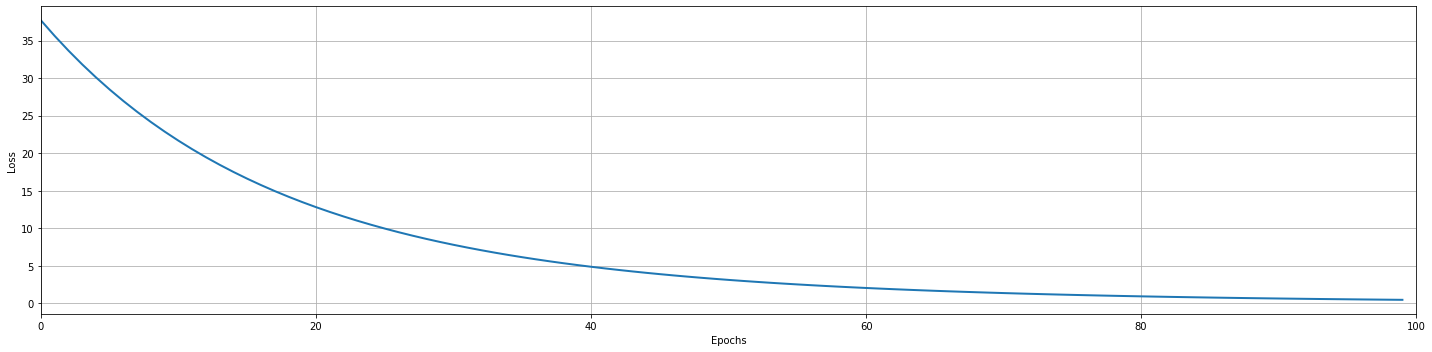

In [31]:
plt.figure(1, figsize=(20,5))
plt.plot(np.arange(num_epochs), loss_values, linewidth=2)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, num_epochs)
plt.tight_layout()